In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/ads_all_cleaned.csv')

# Price

### Outliers

Heavy outliers in Mercedes-Benz with some in Lexus, Ford and Audi.

<Axes: title={'center': 'price'}, xlabel='[brand]'>

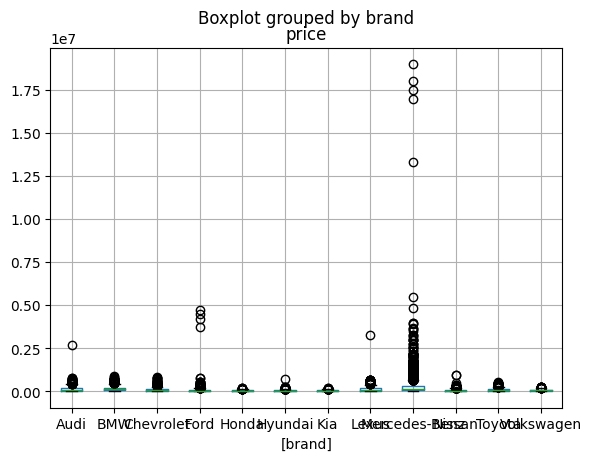

In [2]:
df[['brand','price']].boxplot(by='brand')

Most outliers are from Mercedez

We'll using the following formula to determine what is an outlier and what is not:

Upper Outlier: Q3 + 1.5*IQR

Lower Outlier: Q1 - 1.5*IQR

In [3]:
df['price'].describe()

count    2.087600e+04
mean     1.511642e+05
std      3.470592e+05
min      5.000000e+03
25%      4.000000e+04
50%      8.199900e+04
75%      1.720000e+05
max      1.899900e+07
Name: price, dtype: float64

In [4]:
Q1 = df['price'].describe()[4]
Q3 = df['price'].describe()[6]
IQR = Q3-Q1
outlier_upper = Q3 + 1.5*IQR
outlier_lower = Q1 - 1.5*IQR

In [5]:
outlier_upper

370000.0

**Plotting boxplot for different thresholds of outlier limits**

This is how the boxplot now looks with the outliers removed but I feel this is quite a tight limit.

I'm going to try increasing it to 500,000 and then 1,000,000 just to see the difference

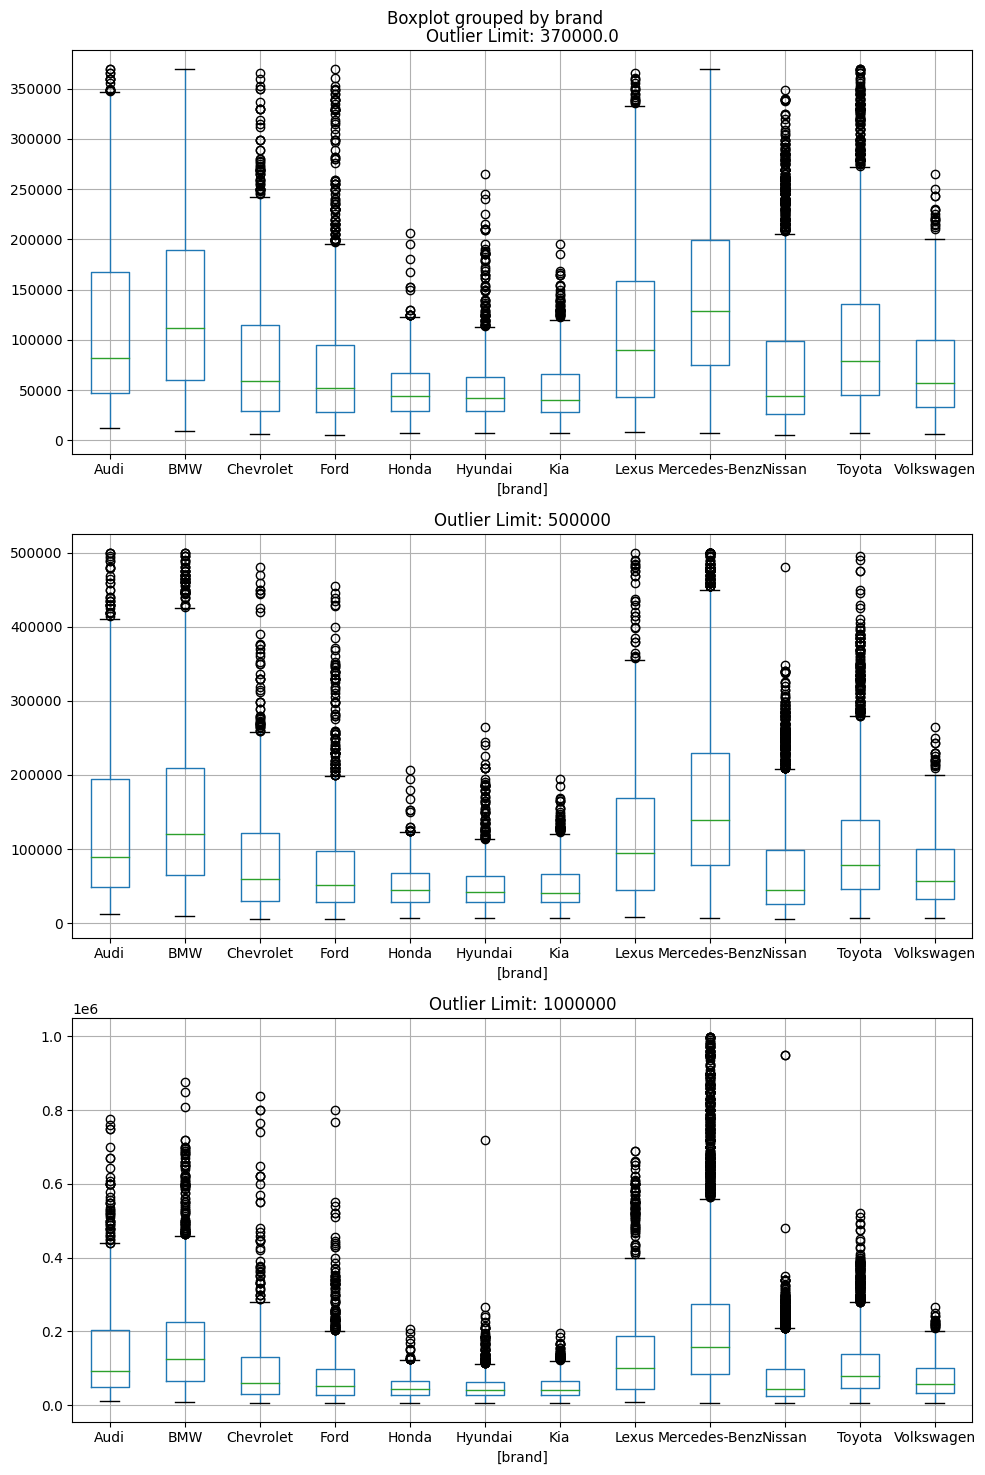

In [6]:
# List of outlier_upper values you want to try
outlier_values = [outlier_upper, 500000, 1000000]

# Create a figure and axes with matplotlib
fig, axs = plt.subplots(len(outlier_values), figsize=(10, 5*len(outlier_values)))

for i, outlier_val in enumerate(outlier_values):
    (
        df[df['price'] < outlier_val]
        .loc[:, ['brand','price']]
        .boxplot(by='brand', ax=axs[i])
    )

    # Set the title for the current plot
    axs[i].set_title(f'Outlier Limit: {outlier_val}')

# Show the plots
plt.tight_layout()
plt.show()

Most outliers are coming from Mercedes

<Axes: xlabel='brand'>

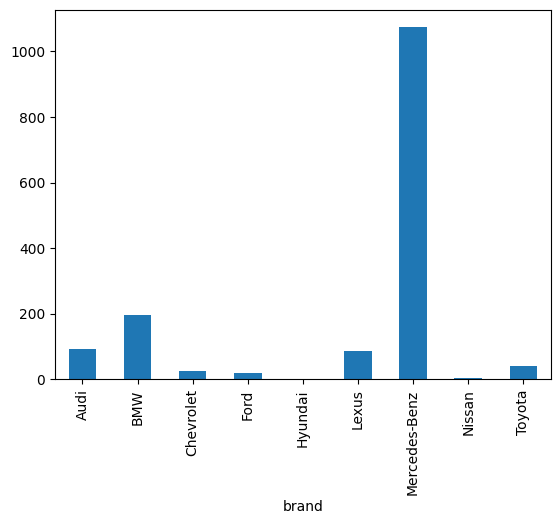

In [7]:
(
    df[df['price'] > outlier_upper]
    .groupby(['brand'])['price']
    .size().plot(kind='bar')
)

Some Mercedes car without a model name seems to be the highest in price

<Axes: xlabel='brand,model'>

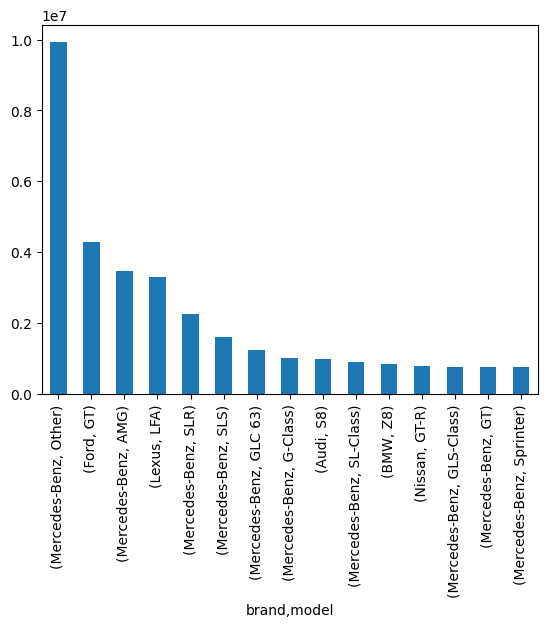

In [8]:
(
    df[df['price'] > outlier_upper]
    .groupby(['brand','model'])['price']
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='bar')
)

### Exploring Mercedez Outliers

This 'Other' vehicle is way out of line. Would be interesting to see what exactly this car is and why it's worth so much.

The price of these top 5 cars are significantly out of range from the rest of the outliers. Definetly need to remove them.

In [9]:
(
    df[(df['price'] > 1000000) & (df['brand'] == 'Mercedes-Benz')]
    .sort_values(by='price', ascending=False)
    .loc[:,['brand','model','title','km','year','price']]
    .head(15)
)

,brand,model,title,km,year,price
17931,Mercedes-Benz,Other,"MERCEDES PROJECT ONE, 2024, LIMITED EDITION, Z...",0.0,2024.0,18999000.0
15760,Mercedes-Benz,AMG,MERCEDES AMG ONE I 1/275 I Brand New,50.0,2023.0,18000000.0
17540,Mercedes-Benz,AMG,Mercedes-Benz AMG ONE,83.0,2023.0,17500000.0
14976,Mercedes-Benz,AMG,2023 Mercedes Benz AMG ONE | Brand New | 1 of ...,0.0,2023.0,16999999.0
18673,Mercedes-Benz,SL-Class,MERCEDES-BENZ 300 SL GULLWING,0.0,1956.0,13299999.0
14998,Mercedes-Benz,G-Class,BRABUS CRAWLER 900 I 1/15 made I Brand New,50.0,2023.0,5500000.0
15531,Mercedes-Benz,G-Class,BRABUS CRAWLER 1 of 15 G900 G63 AMG,30.0,2023.0,4830000.0
14975,Mercedes-Benz,SLS,Mercedes- Benz SLS AMG Black Series | Brand Ne...,0.0,2014.0,3999999.0
16854,Mercedes-Benz,SLS,Mercedes-Benz SLS AMG Black Series 2014 - GCC,829.0,2014.0,3950000.0
16189,Mercedes-Benz,G-Class,"MERCEDES-BENZ BRABUS P900 ROCKET,2024- LIMITED...",214.0,2024.0,3900000.0


**Approaches to take for handling outliers**:
- We may be getting rid of all instances of the car models mentioned below which could impact the model. Meaning if someone were to try and get a price estimate for a G Wagon (a very popular Mercedes car) there will be no data for it
- Determine percentage of data points that would be removed to see potential impact

<Axes: xlabel='model'>

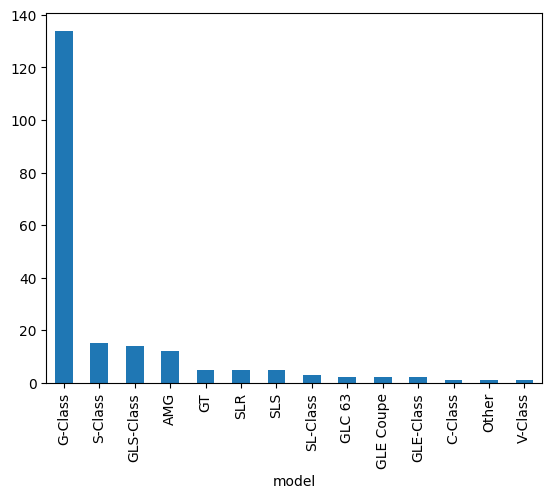

In [10]:
(
    df[(df['price'] > 1000000) & (df['brand'] == 'Mercedes-Benz')]
    .groupby('model')
    .size()
    .sort_values(ascending=False)
    .plot(kind='bar')
)

Determining how many of these cars are outliers out of the whole dataset

Seems like we will be getting rid of a lot of G-Class and S-Class cars both as a percentage and absolute value if we were to use outlier_upper (370,000) as a threshold

I've also included graphs to see how this differs for different outlier thresholds

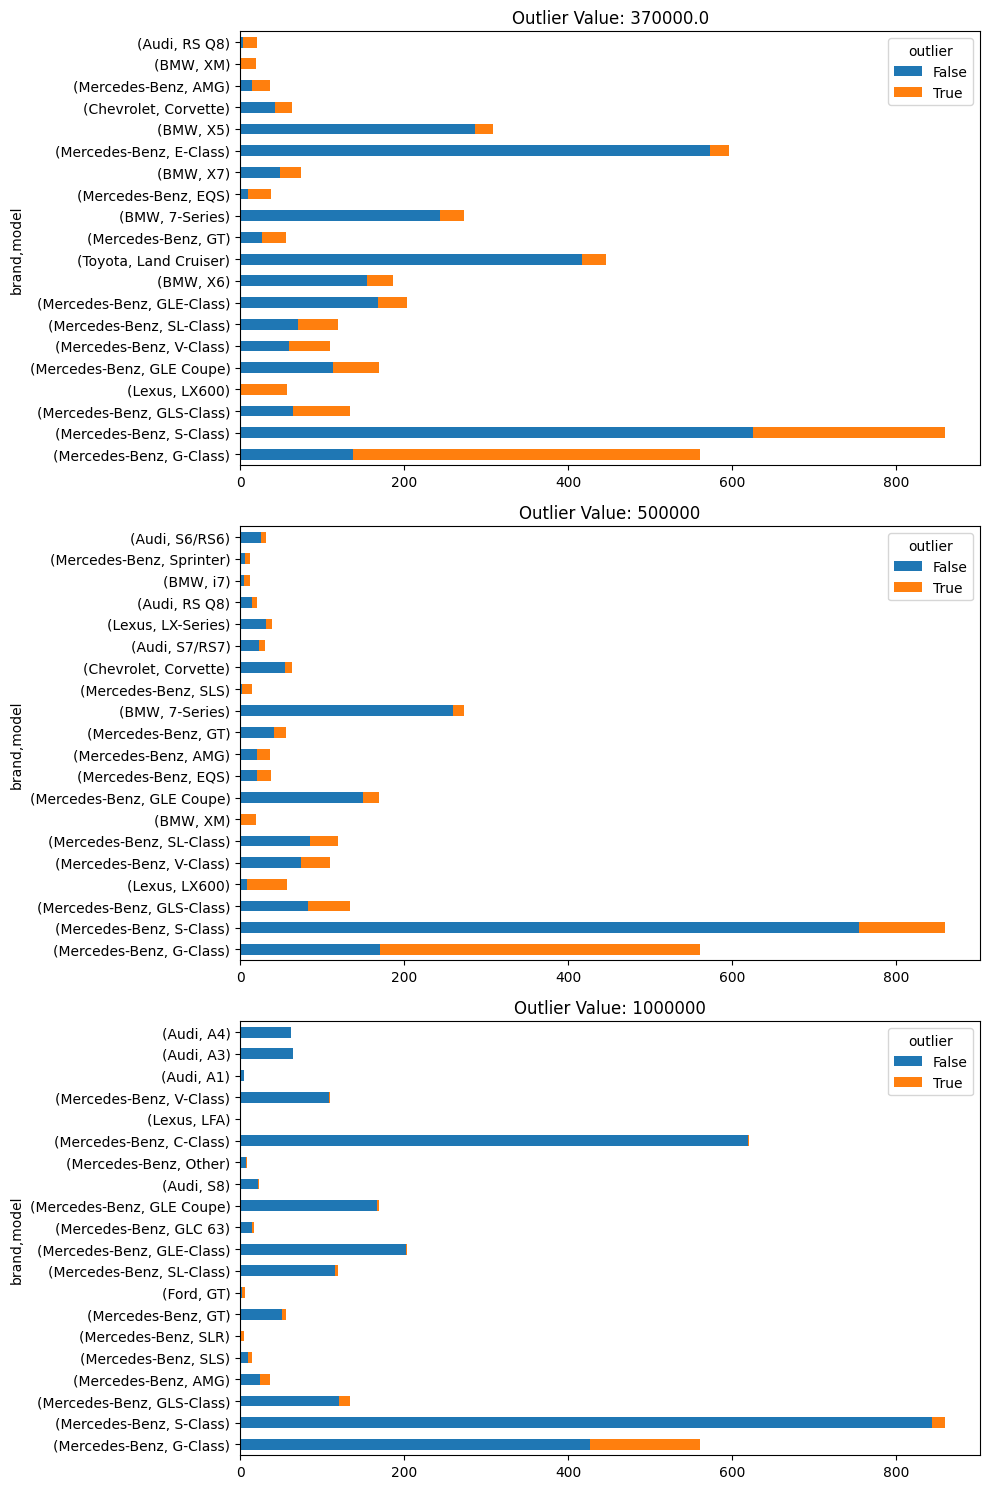

In [11]:
# List of outlier_upper values you want to try
outlier_values = [outlier_upper, 500000, 1000000]

# Create a figure and axes with matplotlib
fig, axs = plt.subplots(len(outlier_values), figsize=(10, 5*len(outlier_values)))

for i, outlier_val in enumerate(outlier_values):
    # Create the plot for the current value of outlier_upper
    (
        df
        .assign(outlier=lambda df: df['price'] > outlier_val)
        .groupby(['brand', 'model', 'outlier'])
        .size()
        .unstack()
        .sort_values(by=True, ascending=False)
        .head(20)
        .plot(kind='barh', stacked=True, ax=axs[i])
    )
    
    # Set the title for the current plot
    axs[i].set_title(f'Outlier Value: {outlier_val}')

# Show the plots
plt.tight_layout()
plt.show()


Doesn't look like we're going to be getting rid of any particular car entirely

<Axes: xlabel='brand,model'>

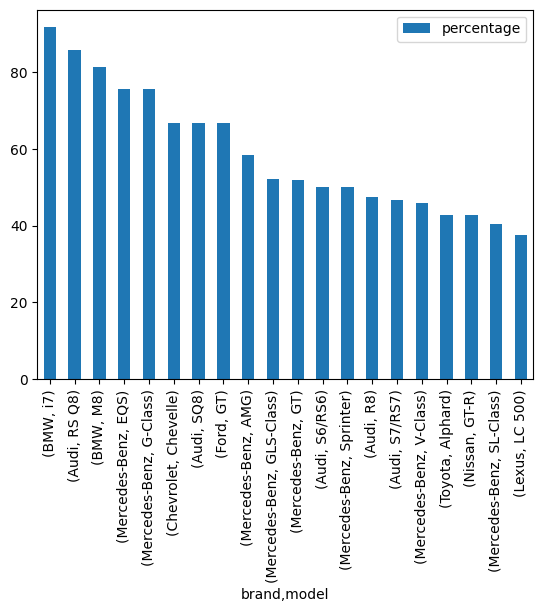

In [13]:
(
    df
    .assign(outlier = lambda df: df['price'] > outlier_upper)
    .groupby(['brand','model','outlier'])
    .size()
    .unstack()
    .assign(percentage = lambda df: (df[True] / (df[True] + df[False])) * 100)
    .sort_values(by='percentage', ascending=False)
    .head(20)
    .plot(kind='bar', y='percentage')
)

### Outlier Removal Conclusion
We can use the IQR formula for dropping outliers. We don't seem to be losing too much data and the 1,000,000 threshold seems to still have plenty outliers so that wouldn't be a good option.